<a href="https://www.kaggle.com/thirumani/predicting-bigg-boss-tamil-season-5-winner?scriptVersionId=84877757" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Predicting Tamil Bigg Boss (பிக் பாஸ் தமிழ்) Season 5 Winner

## Dataset https://www.kaggle.com/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

In [1]:
import datetime
print("Notebook was last executed on:", datetime.date.today().strftime("%Y-%b-%d"))

Notebook was last executed on: 2022-Jan-10


### Importing Required Python Libraries

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
from babel.numbers import format_currency
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

### Check and import dataset

In [3]:
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

-rw-r--r-- 1 nobody nogroup 95026 Jan 10 11:38 /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

There are 750 rows and 24 columns in the dataset


## Exploratory Data Analysis (EDA)

In [4]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,3.0,0,0.0,NaN,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,1.0,0,0.0,NaN,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,1.0,0,0.0,NaN,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,1.0,0,0.0,NaN,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,6.0,0,0.0,NaN,1.0,0.0


In [5]:
bigg_boss.tail(10).T

,740,741,742,743,744,745,746,747,748,749
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,3,3,3,3,3,3,3,3,3,3
Name,Noby Marcose,Ramzan Muhammed,Rithu Manthra,Sai Vishnu,Sandhya Manoj,Soorya Menon,Firoz Khan & Sajna Firoz,Michelle Ann Daniel,Angel Thomas,Remya Panickar
Profession,Actor,Dancer,Singer,Commoner,Dancer,Model,Actor & Actress,Actress,Model,Actress
Gender,Male,Male,Female,Male,Female,Female,Couple,Female,Female,Female
Entry Date,14-Feb-21,14-Feb-21,14-Feb-21,14-Feb-21,14-Feb-21,14-Feb-21,NaN,NaN,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,NaN,NaN,NaN,NaN,10,13,9,3,4,13
Wild Card,No,No,No,No,No,No,Yes,Yes,Yes,Yes
Season Length,95,95,95,95,95,95,95,95,95,95


In [6]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
468,Telugu,3,Mahesh Vitta,Actor,Male,21-Jul-19,13-Oct-19,12.0,No,105,17,21-Jul-19,03-Nov-19,Nagarjuna,Ramya Krishnan,0,Star Maa,18.1,8.0,0,1.0,NaN,0.0,0.0
428,Telugu,1,Aadarsh Balakrishna,Actor,Male,16-Jul-17,24-Sep-17,10.0,No,70,16,16-Jul-17,24-Sep-17,Jr. NTR,NaN,0,Star Maa,15.0,4.0,0,1.0,7.0,1.0,0.0
445,Telugu,2,Babu Gogineni,Activist,Male,10-Jun-18,NaN,9.0,No,112,18,10-Jun-18,30-Sep-18,Nani,NaN,0,Star Maa,15.0,5.0,0,0.0,NaN,0.0,0.0
543,Tamil,2,Nithya Balaji,Commoner - Housewife,Female,17-Jun-18,NaN,4.0,No,105,17,17-Jun-18,30-Sep-18,Kamal Haasan,NaN,0,Star Vijay,8.2,4.0,0,2.0,NaN,0.0,0.0
401,Kannada,7,Raju Talikote,Actor,Male,13-Oct-19,NaN,9.0,No,113,20,13-Oct-19,02-Feb-20,Sudeep,NaN,0,Colors Kannada,NaN,6.0,0,1.0,NaN,0.0,0.0
289,Kannada,1,Rishi Kumar,Swamiji,Male,24-Mar-13,NaN,4.0,No,98,15,24-Mar-13,30-Jun-13,Sudeep,NaN,0,ETV Kannada,4.7,1.0,0,NaN,NaN,0.0,0.0
406,Kannada,7,RJ Prithvi,Radio Jockey,Male,NaN,NaN,7.0,Yes,113,20,13-Oct-19,02-Feb-20,Sudeep,NaN,0,Colors Kannada,NaN,2.0,0,0.0,NaN,0.0,0.0
534,Tamil,1,Harish Kalyan,Actor,Male,NaN,30-Sep-17,14.0,Yes,98,19,25-Jun-17,30-Sep-17,Kamal Haasan,NaN,0,Star Vijay,7.8,4.0,0,1.0,5.0,1.0,0.0
492,Telugu,4,Sujatha,News Presenter,Female,06-Sep-20,11-Oct-20,5.0,No,105,19,06-Sep-20,20-Dec-20,Nagarjuna,Samantha Akkineni,0,Star Maa,20.1,2.0,0,0.0,4.0,0.0,0.0
309,Kannada,2,Srujan Lokesh,Actor,Male,29-Jun-14,NaN,14.0,No,98,15,29-Jun-14,5-Oct-14,Sudeep,NaN,0,Suvarna,NaN,5.0,0,2.0,NaN,1.0,0.0


In [7]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 24 columns):
Language                              750 non-null object
Season Number                         750 non-null int64
Name                                  750 non-null object
Profession                            750 non-null object
Gender                                750 non-null object
Entry Date                            632 non-null object
Elimination Date                      152 non-null object
Elimination Week Number               621 non-null float64
Wild Card                             750 non-null object
Season Length                         750 non-null int64
Number of Housemates                  750 non-null int64
Season Start Date                     750 non-null object
Season End Date                       750 non-null object
Host Name                             750 non-null object
Guest Host Name                       110 non-null object
Prize Money (INR)          

In [8]:
bigg_boss.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Season Number,750.0,5.23,4.00,1.00,2.00,4.0,7.0,15.0
Elimination Week Number,621.0,9.18,4.80,1.00,5.00,9.0,14.0,20.0
Season Length,750.0,103.28,13.60,70.00,98.00,105.0,105.0,143.0
Number of Housemates,750.0,18.56,2.24,15.00,17.00,18.0,20.0,24.0
Average TRP,521.0,8.82,5.55,2.72,3.81,7.8,12.4,20.1
Number of Evictions Faced,732.0,4.24,3.01,0.00,2.00,4.0,6.0,17.0
Number of re-entries,750.0,0.09,0.31,0.00,0.00,0.0,0.0,3.0
Number of times elected as Captain,717.0,0.54,0.75,0.00,0.00,0.0,1.0,5.0
Social Media Popularity,104.0,6.88,1.66,2.00,6.00,7.0,8.0,10.0
Finalist,741.0,0.24,0.43,0.00,0.00,0.0,0.0,1.0


In [9]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [10]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 24 columns):
Language                              750 non-null object
Season Number                         750 non-null int64
Name                                  750 non-null object
Profession                            750 non-null object
Gender                                750 non-null object
Entry Date                            632 non-null datetime64[ns]
Elimination Date                      152 non-null datetime64[ns]
Elimination Week Number               621 non-null Int32
Wild Card                             750 non-null object
Season Length                         750 non-null int64
Number of Housemates                  750 non-null int64
Season Start Date                     750 non-null datetime64[ns]
Season End Date                       750 non-null datetime64[ns]
Host Name                             750 non-null object
Guest Host Name                       110 non-null obje

In [11]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col, "-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 15
Number of unique values in Name - 739
Number of unique values in Profession - 79
Number of unique values in Gender - 4
Number of unique values in Entry Date - 50
Number of unique values in Elimination Date - 90
Number of unique values in Elimination Week Number - 20
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 18
Number of unique values in Number of Housemates - 9
Number of unique values in Season Start Date - 41
Number of unique values in Season End Date - 39
Number of unique values in Host Name - 12
Number of unique values in Guest Host Name - 5
Number of unique values in Prize Money (INR) - 11
Number of unique values in Broadcasted By - 11
Number of unique values in Average TRP - 27
Number of unique values in Number of Evictions Faced - 17
Number of unique values in Number of re-entries - 4
Number of unique values in Number of times elected as Captain - 6
Numb

In [12]:
# Number of seasons in all Indian languages
print("Total", bigg_boss.groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted")
print(bigg_boss['Winner'].sum().astype(int)+1, "seasons completed")
print(bigg_boss.loc[bigg_boss['Winner'].isnull(), :].groupby('Language')['Season Number'].nunique().sum(), "season(s) running")

Total 41 seasons broadcasted
39 seasons completed
2 season(s) running


## Bigg Boss Hindi has many seasons compared to other Indian languages. So, the number of housemates are more in Hindi.

In [13]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        15
Kannada       8
Tamil         5
Telugu        5
Malayalam     3
Marathi       3
Bengali       2
Name: Season Number, dtype: int64


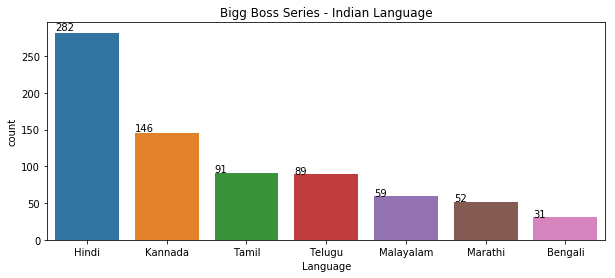

In [14]:
# Total number of Bigg Boss housemates
fig = plt.figure(figsize=(10,4))
ax = sns.countplot(x='Language', data=bigg_boss, order=bigg_boss['Language'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Language')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## In Bigg Boss India seasons, most of the housemates entered in first day/week

No     621
Yes    129
Name: Wild Card, dtype: int64 

No     83%
Yes    17%
Name: Wild Card, dtype: object 



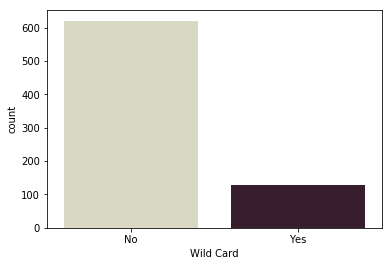

In [15]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'), "\n")
sns.countplot(x='Wild Card', data=bigg_boss, palette="ch:.45")

In [16]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession'] = 'Commoner'

## Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions

Actress                  162
Actor                    120
Soap Actress              60
Model                     57
Singer                    49
Commoner                  40
Soap Actor                37
TV Anchor                 23
Reality Show Alumni       21
Social Media Star         18
Comedian                  18
Radio Jockey              15
News Presenter            13
Choreographer             12
Sports Person              9
Film Director              8
Activist                   7
Video Jockey               6
Politician                 6
International Star         6
Pageant Winner             6
Producer                   5
Controversial Fame         4
Swamiji                    4
Dancer                     4
LGBT                       4
Businessman                3
Wrestler                   3
Musician                   2
Fashion Designer           2
Journalist                 2
Stage Actress              2
Art Director               1
Celebrity Hairstylist      1
Cartoonist    

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]), <a list of 54 Text xticklabel objects>)

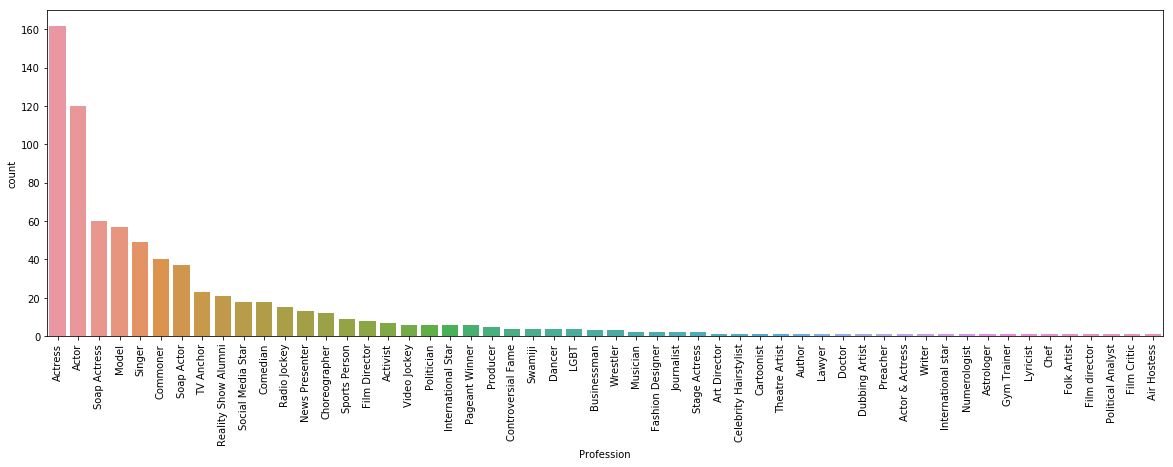

In [17]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20,6))
sns.countplot(x='Profession', data=bigg_boss, order=bigg_boss['Profession'].value_counts().index)
plt.xticks(rotation=90)

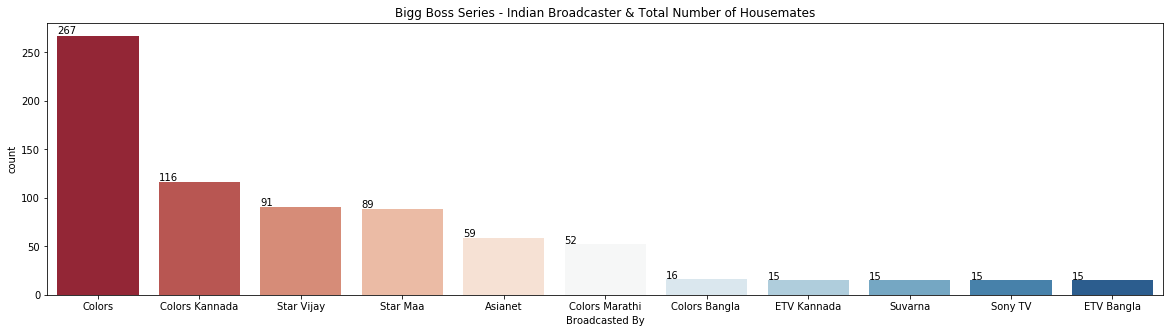

In [18]:
# Broadcaster
fig = plt.figure(figsize=(20,5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu', order=bigg_boss['Broadcasted By'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Broadcaster & Total Number of Housemates')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

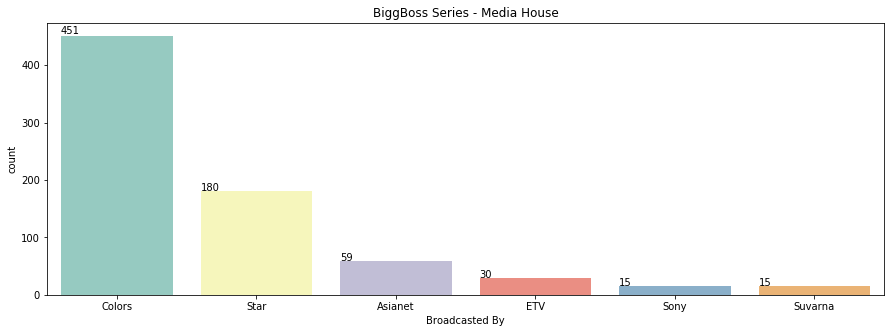

In [19]:
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(bigg_boss['Broadcasted By'].str.split().str.get(0), data=bigg_boss, palette='Set3', order=bigg_boss['Broadcasted By'].str.split().str.get(0).value_counts().index)
ax.set_title('BiggBoss Series - Media House')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [20]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan            12
Sudeep                  8
Kamal Haasan            5
Mahesh Manjrekar        3
Mohanlal                3
Nagarjuna               3
Mithun Chakraborthy     2
Amitabh Bachchan        1
Arshad Warsi            1
Jr. NTR                 1
Nani                    1
Shilpa Shetty           1
Name: Season Number, dtype: int64

In [21]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

Guest Host Name
Ramya Krishnan       2
Farah Khan           1
Samantha Akkineni    1
Sanjay Dutt          1
Siddhartha Jadhav    1
Name: Season Number, dtype: int64

## In all Bigg Boss competitions, in languages and in all seasons, Female contestants are more

Female         391
Male           352
Transgender      6
Couple           1
Name: Gender, dtype: int64 

Female         52%
Male           47%
Transgender     1%
Couple          0%
Name: Gender, dtype: object


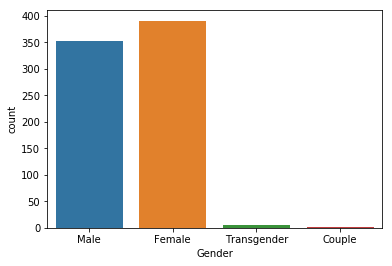

In [22]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

sns.countplot(data = bigg_boss, x = 'Gender')

### Only 6 Transgenders (LGBT) participated in all Indian languages

In [23]:
# Maximum TRP of Bigg Boss India seasons (Big Brother in India)
print("Maximum TRP", bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 20.1 

Language  Season Number
  Telugu              4


In [24]:
# Smallest season of Indian Bigg Boss seasons
print("Smallest season", bigg_boss['Season Length'].min(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].min()][["Language","Season Number"]].head(1).to_string(index=False))

Smallest season 70 days 

Language  Season Number
  Telugu              1


In [25]:
# Longest season of Bigg Boss Indian seasons
print("Longest season", bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 143 days 

Language  Season Number
   Hindi             14


In [26]:
print("Maximum number of contestants in one season:", bigg_boss['Number of Housemates'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Housemates']==bigg_boss['Number of Housemates'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum number of contestants in one season: 24 

Language  Season Number
   Hindi             15


In [27]:
print("Maximum number of evictions faced in one season:", bigg_boss['Number of Evictions Faced'].max(), "\n")
print("\nTop 3 contestants who faced maximum number of evictions\n")
print(bigg_boss.loc[bigg_boss['Number of Evictions Faced']>=bigg_boss['Number of Evictions Faced'].max()-3][["Language","Season Number","Name","Number of Evictions Faced"]].head(3).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

Maximum number of evictions faced in one season: 17 


Top 3 contestants who faced maximum number of evictions

Language  Season Number                Name  Number of Evictions Faced
   Hindi             14       Rubina Dilaik                         17
 Kannada              8  Prashanth Sambargi                         15
   Hindi             14        Rahul Vaidya                         14


In [28]:
bigg_boss['Season Length in weeks'] = round(bigg_boss['Season Length']/7,0).astype(pd.Int32Dtype())
bigg_boss['Evictions Faced Percentage'] = round(bigg_boss['Number of Evictions Faced']/bigg_boss['Season Length in weeks']*100,0).astype(pd.Int32Dtype())
print("Maximum percentage of evictions faced in one season:", bigg_boss['Evictions Faced Percentage'].max(), "%\n")
print("\nTop 3 contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
print(bigg_boss.loc[bigg_boss['Evictions Faced Percentage']>=bigg_boss['Evictions Faced Percentage'].max()-5][["Language","Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(3).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

Maximum percentage of evictions faced in one season: 88 %


Top 3 contestants who faced maximum percentage of evictions (they were in nominations almost every week)

  Language  Season Number                Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
   Kannada              8  Prashanth Sambargi                         15                      17                          88
 Malayalam              3          Sai Vishnu                         12                      14                          86
     Hindi             14       Rubina Dilaik                         17                      20                          85


In [29]:
print("Maximum number of re-entries:", bigg_boss['Number of re-entries'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of re-entries']>=bigg_boss['Number of re-entries'].max()-1][["Language","Season Number","Name","Number of re-entries"]].head(5).sort_values("Number of re-entries",ascending=False).to_string(index=False))

Maximum number of re-entries: 3 

Language  Season Number          Name  Number of re-entries
   Hindi             14   Vikas Gupta                     3
  Telugu              1  Mumaith Khan                     2
  Telugu              2   Nutan Naidu                     2


In [30]:
print("Maximum number of times elected as captain:", bigg_boss['Number of times elected as Captain'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of times elected as Captain']>=bigg_boss['Number of times elected as Captain'].max()-1][["Language","Season Number","Name","Number of times elected as Captain"]].head(6).sort_values("Number of times elected as Captain",ascending=False).to_string(index=False))

Maximum number of times elected as captain: 5 

  Language  Season Number            Name  Number of times elected as Captain
     Hindi             12     Surbhi Rana                                   5
     Hindi              9   Prince Narula                                   4
     Hindi             10  Manveer Gurjar                                   4
 Malayalam              2   Saju Navodaya                                   4


In [31]:
# Many contestants entered via wild card, but 19 people managed to go to Finale
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
44,Hindi,3,Pravesh Rana,Model,Male,NaT,NaT,12,Yes,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,2.83,4,0,0,NaN,1,0.0,12,33
59,Hindi,4,Dalip Singh Rana (Khali),Wrestler,Male,NaT,2011-01-08,14,Yes,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,2,0,2,NaN,1,0.0,14,14
60,Hindi,4,Dolly Bindra,Actress,Female,NaT,2011-01-08,14,Yes,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,4,0,1,NaN,1,0.0,14,29
75,Hindi,5,Amar Upadhyay,Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,7,0,1,NaN,1,0.0,14,50
76,Hindi,5,Siddharth Bhardwaj,Reality Show Alumni,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,5,0,0,NaN,1,0.0,14,36
77,Hindi,5,Akashdeep Saigal,Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,5,0,1,NaN,1,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,3.81,6,1,1,NaN,1,0.0,14,43
115,Hindi,7,Ajaz Khan,Actor,Male,NaT,2013-12-28,15,Yes,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,4.40,7,0,0,NaN,1,0.0,15,47
133,Hindi,8,Ali Quli Mirza,Singer,Male,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,6,0,1,NaN,1,0.0,15,40
135,Hindi,8,Dimpy Ganguly,TV Anchor,Female,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,5,0,1,NaN,1,0.0,15,33


## About Winners only

In [32]:
print("Total Bigg Boss season winners", bigg_boss['Winner'].sum().astype(int), "(out of", bigg_boss['Finalist'].sum(), "finalists)")
# For Malayalam Season 2 winner was not declared

Total Bigg Boss season winners 38 (out of 181 finalists)


In [33]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,2006-11-03,NaT,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony TV,2.72,4,0,0,NaN,1,1.0,12,33
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,2.89,4,0,0,NaN,1,1.0,14,29
42,Hindi,3,Vindu Dara Singh,Actor,Male,2009-10-04,NaT,NaN,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,2.83,7,0,0,NaN,1,1.0,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,2010-10-03,NaT,NaN,No,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,4.95,4,0,2,NaN,1,1.0,14,29
62,Hindi,5,Juhi Parmar,Soap Actress,Female,2011-10-02,NaT,NaN,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,4.19,4,0,1,NaN,1,1.0,14,29
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,2012-10-07,NaT,NaN,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,3.81,6,0,1,NaN,1,1.0,14,43
102,Hindi,7,Gauhar Khan,Actress,Female,2013-09-15,NaT,NaN,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,4.40,7,0,2,NaN,1,1.0,15,47
121,Hindi,8,Gautam Gulati,Actor,Male,2014-09-21,NaT,NaN,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,5000000.0,Colors,3.77,10,0,1,NaN,1,1.0,15,67
144,Hindi,9,Prince Narula,Reality Show Alumni,Male,2015-10-11,NaT,NaN,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,2.90,6,0,4,NaN,1,1.0,15,40
165,Hindi,10,Manveer Gurjar,Commoner,Male,2016-10-16,NaT,NaN,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,5000000.0,Colors,3.54,7,0,4,8,1,1.0,15,47


In [34]:
# Sum of prize money won by all BB Season winners/participants, in India
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN').replace(".00", ""))

# 21 crores and 3 lakh rupees

₹ 21,03,00,000


In [35]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Profession'].value_counts()

Actor                  10
Actress                 5
Soap Actress            5
Singer                  4
Soap Actor              3
Reality Show Alumni     3
TV Anchor               2
Commoner                2
Comedian                1
Film Director           1
Video Jockey            1
Model                   1
Name: Profession, dtype: int64

In [36]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(),'\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

Male      28
Female    10
Name: Gender, dtype: int64 

Male      74%
Female    26%
Name: Gender, dtype: object


## No wild card entry housemate won the Bigg Boss competition.

In [37]:
# Entry type of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Wild Card'].value_counts()

No    38
Name: Wild Card, dtype: int64

In [38]:
bigg_boss.loc[bigg_boss.Winner==1, 'Season Length'].value_counts().sort_index()

# Length of the season - Number of Winners

70      1
84      1
86      1
90      1
95      1
96      1
97      2
98     10
100     1
105    11
106     2
112     2
113     1
117     1
140     1
143     1
Name: Season Length, dtype: int64

In [39]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Housemates'].value_counts().sort_index()

# Number of Housemates in house - Number of Winners

15    6
16    3
17    5
18    9
19    6
20    7
22    2
Name: Number of Housemates, dtype: int64

In [40]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

4     7
5     4
6     5
7     6
8     1
9     7
10    1
11    2
12    3
17    1
Name: Number of Evictions Faced, dtype: int64

In [41]:
# No re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1, 'Number of re-entries'].value_counts()

0    38
Name: Number of re-entries, dtype: int64

In [42]:
# Bigg Boss title winners number of times elected as captain
bigg_boss.loc[bigg_boss.Winner==1, 'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain - Number of winners

0    10
1    11
2    12
3     1
4     2
Name: Number of times elected as Captain, dtype: int64

## BB Tamil Seasons

In [43]:
lang='Tamil'

# All Bigg Boss Tamil Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
517,Tamil,1,Aarav Nafeez,Model,Male,2017-06-25,NaT,NaN,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,5000000.0,Star Vijay,7.8,7,0,1,7,1,1.0,14,50
518,Tamil,1,Anuya Bhagvath,Actress,Female,2017-06-25,NaT,1,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,0.0,Star Vijay,7.8,1,0,0,NaN,0,0.0,14,7
519,Tamil,1,Bharani,Actor,Male,2017-06-25,NaT,2,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,0.0,Star Vijay,7.8,1,0,0,NaN,0,0.0,14,7
520,Tamil,1,Ganesh Venkatraman,Actor,Male,2017-06-25,2017-09-30,14,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,0.0,Star Vijay,7.8,6,0,1,5,1,0.0,14,43
521,Tamil,1,Ganja Karuppu,Comedian,Male,2017-06-25,NaT,2,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,0.0,Star Vijay,7.8,1,0,0,NaN,0,0.0,14,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,Tamil,5,Suruthi Periyasamy,Model,Female,2021-10-03,NaT,5,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,3,0,0,NaN,0,0.0,15,20
604,Tamil,5,Thamarai Selvi,Folk Artist,Female,2021-10-03,NaT,14,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,8,0,2,NaN,0,0.0,15,53
605,Tamil,5,Varun,Actor,Male,2021-10-03,NaT,12,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,5,0,1,NaN,0,0.0,15,33
606,Tamil,5,Amir,Choreographer,Male,NaT,NaT,NaN,Yes,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,2,0,1,8,1,NaN,15,13


In [44]:
# Bigg Boss Tamil Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
517,Tamil,1,Aarav Nafeez,Model,Male,2017-06-25,NaT,NaN,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,5000000.0,Star Vijay,7.8,7,0,1,7,1,1.0,14,50
546,Tamil,2,Riythvika,Actress,Female,2018-06-17,NaT,NaN,No,105,17,2018-06-17,2018-09-30,Kamal Haasan,NaN,5000000.0,Star Vijay,8.2,6,0,1,8,1,1.0,15,40
560,Tamil,3,Mugen Rao,Singer,Male,2019-06-23,NaT,NaN,No,105,17,2019-06-23,2019-10-06,Kamal Haasan,NaN,5000000.0,Star Vijay,8.8,4,0,2,8,1,1.0,15,27
571,Tamil,4,Aari Arjunan,Actor,Male,2020-10-04,NaT,NaN,No,105,18,2020-10-04,2021-01-17,Kamal Haasan,NaN,5000000.0,Star Vijay,15.6,11,0,2,9,1,1.0,15,73


In [45]:
# Tamil Bigg Boss all seasons finalists
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
517,Tamil,1,Aarav Nafeez,Model,Male,2017-06-25,NaT,NaN,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,5000000.0,Star Vijay,7.8,7,0,1,7,1,1.0,14,50
520,Tamil,1,Ganesh Venkatraman,Actor,Male,2017-06-25,2017-09-30,14,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,0.0,Star Vijay,7.8,6,0,1,5,1,0.0,14,43
529,Tamil,1,Snehan,Lyricist,Male,2017-06-25,2017-09-30,14,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,0.0,Star Vijay,7.8,6,0,3,6,1,0.0,14,43
534,Tamil,1,Harish Kalyan,Actor,Male,NaT,2017-09-30,14,Yes,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,0.0,Star Vijay,7.8,4,0,1,5,1,0.0,14,29
536,Tamil,2,Aishwarya Dutta,Actress,Female,2018-06-17,2018-09-30,15,No,105,17,2018-06-17,2018-09-30,Kamal Haasan,NaN,0.0,Star Vijay,8.2,5,0,2,7,1,0.0,15,33
539,Tamil,2,Janani Iyer,Actress,Female,2018-06-17,2018-09-30,15,No,105,17,2018-06-17,2018-09-30,Kamal Haasan,NaN,0.0,Star Vijay,8.2,6,0,1,5,1,0.0,15,40
546,Tamil,2,Riythvika,Actress,Female,2018-06-17,NaT,NaN,No,105,17,2018-06-17,2018-09-30,Kamal Haasan,NaN,5000000.0,Star Vijay,8.2,6,0,1,8,1,1.0,15,40
552,Tamil,2,Vijayalakshmi,Actress,Female,NaT,2018-09-30,15,Yes,105,17,2018-06-17,2018-09-30,Kamal Haasan,NaN,0.0,Star Vijay,8.2,4,0,0,6,1,0.0,15,27
558,Tamil,3,Losliya Mariyanesan,News Presenter,Female,2019-06-23,NaT,15,No,105,17,2019-06-23,2019-10-06,Kamal Haasan,NaN,0.0,Star Vijay,8.8,6,0,1,6,1,0.0,15,40
560,Tamil,3,Mugen Rao,Singer,Male,2019-06-23,NaT,NaN,No,105,17,2019-06-23,2019-10-06,Kamal Haasan,NaN,5000000.0,Star Vijay,8.8,4,0,2,8,1,1.0,15,27


In [46]:
# Number of finalists gender wise, in each BB Tamil season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Gender')['Season Number'].value_counts().sort_index()

# First season all Male finalists, second season all Female finalists
# Third season 50% Male & 50% Female finalists

Gender  Season Number
Female  2                4
        3                2
        4                1
        5                2
Male    1                4
        3                2
        4                4
        5                3
Name: Season Number, dtype: int64

In [47]:
# Bigg Boss Tamil current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']==5), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
588,Tamil,5,Abhinay Vaddi,Actor,Male,2021-10-03,NaT,11,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,9,0,1,NaN,0,0.0,15,60
589,Tamil,5,Abishek Raaja,Social Media Star,Male,2021-10-03,NaT,9,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,3,1,0,NaN,0,0.0,15,20
590,Tamil,5,Akshara Reddy,Pageant Winner,Female,2021-10-03,NaT,12,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,10,0,0,NaN,0,0.0,15,67
591,Tamil,5,Chinnaponnu,Singer,Female,2021-10-03,NaT,4,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,3,0,0,NaN,0,0.0,15,20
592,Tamil,5,Ciby,Actor,Male,2021-10-03,NaT,14,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,1200000.0,Star Vijay,18.6,9,0,1,NaN,0,0.0,15,60
593,Tamil,5,Imman Annachi,Comedian,Male,2021-10-03,NaT,10,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,7,0,1,NaN,0,0.0,15,47
594,Tamil,5,Isaivani,Singer,Female,2021-10-03,NaT,7,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,5,0,1,NaN,0,0.0,15,33
595,Tamil,5,Iykki Berry,Singer,Female,2021-10-03,NaT,8,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,5,0,0,NaN,0,0.0,15,33
596,Tamil,5,Mathumitha,Model,Female,2021-10-03,NaT,6,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,3,0,1,NaN,0,0.0,15,20
597,Tamil,5,Nadia Chang,Model,Female,2021-10-03,NaT,2,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.6,1,0,0,NaN,0,0.0,15,7


In [48]:
# Bigg Boss Tamil Housemate's Gender
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Gender'].value_counts(), "\n")

Female         50
Male           40
Transgender     1
Name: Gender, dtype: int64 



In [49]:
print("\nTop 5 Tamil contestants who faced maximum number of evictions\n")
tmax=bigg_boss.loc[(bigg_boss['Language']==lang),'Number of Evictions Faced'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Number of Evictions Faced']>=tmax-2)][["Season Number","Name","Number of Evictions Faced"]].head(6).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))


Top 5 Tamil contestants who faced maximum number of evictions

 Season Number                Name  Number of Evictions Faced
             5        Pavani Reddy                         12
             4        Aari Arjunan                         11
             5       Akshara Reddy                         10
             5  Priyanka Deshpande                         10


In [50]:
print("\nTop Tamil contestant(s) who faced maximum percentage of evictions (they were in nominations almost every week)\n")
tpmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Evictions Faced Percentage'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Evictions Faced Percentage']>=tpmax-10)][["Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(6).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))


Top Tamil contestant(s) who faced maximum percentage of evictions (they were in nominations almost every week)

 Season Number          Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
             5  Pavani Reddy                         12                      15                          80
             4  Aari Arjunan                         11                      15                          73


## Preparing Data for ML modelling

In [51]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                0
Season Number                           0
Name                                    0
Profession                              0
Gender                                  0
Entry Date                            118
Elimination Date                      598
Elimination Week Number               129
Wild Card                               0
Season Length                           0
Number of Housemates                    0
Season Start Date                       0
Season End Date                         0
Host Name                               0
Guest Host Name                       640
Prize Money (INR)                      14
Broadcasted By                          0
Average TRP                           229
Number of Evictions Faced              18
Number of re-entries                    0
Number of times elected as Captain     33
Social Media Popularity               646
Finalist                                9
Winner                            

In [52]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [53]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].fillna(0)

In [54]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 30 columns):
Language                              750 non-null object
Season Number                         750 non-null int64
Name                                  750 non-null object
Profession                            750 non-null object
Gender                                750 non-null object
Entry Date                            632 non-null datetime64[ns]
Elimination Date                      152 non-null datetime64[ns]
Elimination Week Number               621 non-null Int32
Wild Card                             750 non-null object
Season Length                         750 non-null int64
Number of Housemates                  750 non-null int64
Season Start Date                     750 non-null datetime64[ns]
Season End Date                       750 non-null datetime64[ns]
Host Name                             750 non-null object
Guest Host Name                       110 non-null obje

In [55]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,3,0,0,NaN,0,0.0,12,25,2006,2007,4,1
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Bobby Darling,LGBT,Transgender,2006-11-03,NaT,1,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,6,0,0,NaN,1,0.0,12,50,2006,2007,4,1


In [56]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
745,Malayalam,3,Soorya Menon,Model,Female,2021-02-14,NaT,13,No,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,8,0,1,NaN,0,0.0,14,57,2021,2021,1,2
746,Malayalam,3,Firoz Khan & Sajna Firoz,Actor & Actress,Couple,NaT,NaT,9,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,7,0,0,NaN,0,0.0,14,50,2021,2021,1,2
747,Malayalam,3,Michelle Ann Daniel,Actress,Female,NaT,NaT,3,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,1,0,0,NaN,0,0.0,14,7,2021,2021,1,2
748,Malayalam,3,Angel Thomas,Model,Female,NaT,NaT,4,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,1,0,0,NaN,0,0.0,14,7,2021,2021,1,2
749,Malayalam,3,Remya Panickar,Actress,Female,NaT,NaT,13,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,3,1,1,NaN,0,0.0,14,21,2021,2021,1,2


In [57]:
# Updating last week-end elimination/entries manually
# bigg_boss.iloc[592,23] = 0

In [58]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
420,Kannada,8,Shamanth Gowda,Social Media Star,Male,2021-02-28,NaT,16,No,117,20,2021-02-28,2021-08-08,Sudeep,NaN,0.0,Colors Kannada,8.82048,8,0,2,NaN,0,0.0,17,47,2021,2021,1,3
651,Marathi,3,Sneha Wagh,Soap Actress,Female,2021-09-19,NaT,9,No,98,17,2021-09-19,2021-12-26,Mahesh Manjrekar,Siddhartha Jadhav,0.0,Colors Marathi,8.82048,4,0,1,NaN,0,0.0,14,29,2021,2021,3,4
407,Kannada,7,Raksha Somashekhar,Actress,Female,NaT,NaT,8,Yes,113,20,2019-10-13,2020-02-02,Sudeep,NaN,0.0,Colors Kannada,8.82048,1,0,0,NaN,0,0.0,16,6,2019,2020,4,1
593,Tamil,5,Imman Annachi,Comedian,Male,2021-10-03,NaT,10,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,18.60000,7,0,1,NaN,0,0.0,15,47,2021,2022,4,1
333,Kannada,4,Karunya Ram,Actress,Female,2016-10-09,NaT,NaN,No,112,18,2016-10-09,2017-01-29,Sudeep,NaN,0.0,Colors Kannada,8.82048,1,0,0,NaN,0,0.0,16,NaN,2016,2017,4,1
662,Bengali,1,Iris Maity,Actress,Female,2013-06-17,NaT,7,No,90,15,2013-06-17,2013-09-14,Mithun Chakraborthy,NaN,0.0,ETV Bangla,2.90000,2,0,0,NaN,0,0.0,13,15,2013,2013,2,3
158,Hindi,10,Antara Biswas,Actress,Female,2016-10-16,NaT,14,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,3.54000,9,0,0,NaN,0,0.0,15,60,2016,2017,4,1
478,Telugu,3,Shilpa Chakravarthy,TV Anchor,Female,2019-09-02,2019-09-15,8,Yes,100,17,2019-07-21,2019-11-03,Nagarjuna,Ramya Krishnan,0.0,Star Maa,18.10000,1,0,0,NaN,0,0.0,14,7,2019,2019,3,4
372,Kannada,6,AV Ravi,Actor,Male,2018-10-21,NaT,5,No,100,20,2018-10-21,2019-01-27,Sudeep,NaN,0.0,Colors Kannada,8.82048,3,0,1,NaN,0,0.0,14,21,2018,2019,4,1
112,Hindi,7,VJ Andy,Video Jockey,Male,2013-09-15,NaT,14,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,4.40000,8,0,1,NaN,0,0.0,15,53,2013,2013,3,4


In [59]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Tamil season

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
599,Tamil,5,Niroop,Pageant Winner,Male,2021-10-03,NaT,NaN,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,9,0,1,8,1,NaN,15,60,2021,2022,4,1
600,Tamil,5,Pavani Reddy,Soap Actress,Female,2021-10-03,NaT,NaN,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,12,0,1,9,1,NaN,15,80,2021,2022,4,1
601,Tamil,5,Priyanka Deshpande,TV Anchor,Female,2021-10-03,NaT,NaN,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,10,0,1,9,1,NaN,15,67,2021,2022,4,1
602,Tamil,5,Raju Jeyamohan,Actor,Male,2021-10-03,NaT,NaN,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,7,0,0,9,1,NaN,15,47,2021,2022,4,1
606,Tamil,5,Amir,Choreographer,Male,NaT,NaT,NaN,Yes,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,2,0,1,8,1,NaN,15,13,2021,2022,4,1


In [60]:
BB_tamil_participant = test[['Name']]
BB_tamil_participant.reset_index(drop=True, inplace=True)
BB_tamil_participant

,Name
0,Niroop
1,Pavani Reddy
2,Priyanka Deshpande
3,Raju Jeyamohan
4,Amir


In [61]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date",], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [62]:
train.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Soap Actor,Male,10,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,3,0,0,NaN,0,0.0,12,25,2006,2007,4,1
1,Hindi,1,Model,Female,5,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Pageant Winner,Male,4,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,LGBT,Transgender,1,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Model,Female,12,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,6,0,0,NaN,1,0.0,12,50,2006,2007,4,1


In [63]:
test.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
599,Tamil,5,Pageant Winner,Male,NaN,No,105,20,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,9,0,1,8,1,15,60,2021,2022,4,1
600,Tamil,5,Soap Actress,Female,NaN,No,105,20,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,12,0,1,9,1,15,80,2021,2022,4,1
601,Tamil,5,TV Anchor,Female,NaN,No,105,20,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,10,0,1,9,1,15,67,2021,2022,4,1
602,Tamil,5,Actor,Male,NaN,No,105,20,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,7,0,0,9,1,15,47,2021,2022,4,1
606,Tamil,5,Choreographer,Male,NaN,Yes,105,20,Kamal Haasan,Ramya Krishnan,NaN,Star Vijay,18.6,2,0,1,8,1,15,13,2021,2022,4,1


In [64]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

0.0    94.836957
1.0     5.163043
Name: Winner, dtype: float64


In [65]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [66]:
print(train2.shape)
print(test.shape)

(736, 313)
(5, 313)


In [67]:
train2.isnull().sum().sort_values(ascending=False)

Season Ending Quarter_4      0
Season Length_106            0
Season Length_90             0
Season Length_95             0
Season Length_96             0
                            ..
Social Media Popularity_5    0
Social Media Popularity_6    0
Social Media Popularity_7    0
Social Media Popularity_8    0
Language_Hindi               0
Length: 313, dtype: int64

In [68]:
train2.drop(["Profession_Folk Artist"], axis=1, inplace=True)
test.drop(["Profession_Folk Artist"], axis=1, inplace=True)

In [69]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Season Number_14,Season Number_15,Profession_Actor,Profession_Actor & Actress,Profession_Actress,Profession_Air Hostess,Profession_Art Director,...,Season Starting Year_2017,Season Starting Year_2018,Season Starting Year_2019,Season Starting Year_2020,Season Starting Year_2021,Season Ending Year_2008,Season Ending Year_2009,Season Ending Year_2011,Season Ending Year_2012,Season Ending Year_2013,Season Ending Year_2014,Season Ending Year_2015,Season Ending Year_2016,Season Ending Year_2017,Season Ending Year_2018,Season Ending Year_2019,Season Ending Year_2020,Season Ending Year_2021,Season Ending Year_2022,Season Starting Quarter_2,Season Starting Quarter_3,Season Starting Quarter_4,Season Ending Quarter_2,Season Ending Quarter_3,Season Ending Quarter_4
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [70]:
target.values

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.

In [71]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=2020)
print(x_train.shape, x_val.shape)

(515, 312) (221, 312)


In [72]:
x_train.isnull().sum().sort_values(ascending=False)

Season Ending Quarter_4      0
Season Length_112            0
Season Length_95             0
Season Length_96             0
Season Length_97             0
                            ..
Social Media Popularity_6    0
Social Media Popularity_7    0
Social Media Popularity_8    0
Social Media Popularity_9    0
Language_Hindi               0
Length: 312, dtype: int64

## Machine Learning Modelling

In [73]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues');
    ax.set_xlabel('True Label',size=12)
    ax.set_ylabel('Predicted Label',size=12)

In [74]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2021, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=0.01: 93.2650410591587
F1 score for C=1: 98.52754857599149
F1 score for C=10: 99.53613857177524
F1 score for C=100: 99.53613857177524
F1 score for C=1000: 99.53613857177524


In [75]:
logi = LogisticRegression(random_state=2021, C=10).fit(x_train, y_train)
logi

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2021, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 99.1340032516503
Accuracy Score - 99.09502262443439


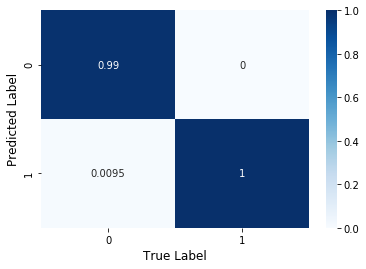

In [77]:
# Confusion Matrix
plot_confusion_matrix()

# TP 0.98 TN 0.86

In [78]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_tamil_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
0,Niroop,0.153353
1,Pavani Reddy,0.126762
3,Raju Jeyamohan,0.103611
2,Priyanka Deshpande,0.043926
4,Amir,0.003033


## Predicted Winner for Bigg Boss Tamil Season 5, as per Logistic Regression

In [79]:
# Predicted Winner for Bigg Boss Tamil Season 5, as per LogisticRegression
winner_lg[winner_lg['Predicted_Winner'] == np.amax(winner_lg.Predicted_Winner)]

,Name,Predicted_Winner
0,Niroop,0.153353


In [80]:
# Random Forest
rf = RandomForestClassifier(n_estimators=5000, random_state=2021).fit(x_train, y_train)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=None, oob_score=False, random_state=2021,
                       verbose=0, warm_start=False)

In [81]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=100 accuracy 99.4
# n_estimators=200 accuracy 100

F1 Score - 99.1340032516503
Accuracy Score - 99.09502262443439


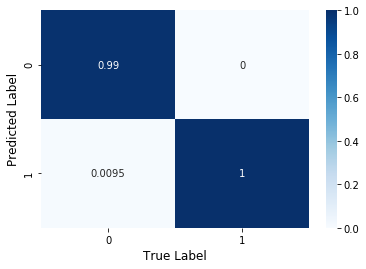

In [82]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.88

In [83]:
predicted_val_rf = rf.predict_proba(test)[:,1]
winner_rf = pd.concat([BB_tamil_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])],axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
1,Pavani Reddy,0.2524
3,Raju Jeyamohan,0.1672
2,Priyanka Deshpande,0.1598
0,Niroop,0.0980
4,Amir,0.0620


## Predicted Winner for Bigg Boss Tamil Season 5, as per Random Forest

In [84]:
# Predicted Winner for Bigg Boss Tamil Season 5, as per RandomForest
winner_rf[winner_rf['Predicted_Winner'] == np.amax(winner_rf.Predicted_Winner)]

,Name,Predicted_Winner
1,Pavani Reddy,0.2524


## Machine Learning (ML) models to predict Indian BiggBoss (Big Brother) season Winners

## Hindi Bigg Boss Season15
## https://www.kaggle.com/thirumani/predicting-bigg-boss-hindi-season-15-winner

## Kannada Bigg Boss Season8
## https://www.kaggle.com/thirumani/predicting-bigg-boss-kannada-season-8-winner

## Telugu Bigg Boss Season5
## https://www.kaggle.com/thirumani/predicting-bigg-boss-telugu-season-5-winner

## Malayalam Bigg Boss Season3
## https://www.kaggle.com/thirumani/predicting-bigg-boss-malayalam-season-3-winner

## Marathi Bigg Boss Season3
## https://www.kaggle.com/thirumani/predicting-bigg-boss-marathi-season-3-winner

In [85]:
text = " BiggBoss ".join(cat for cat in bigg_boss['Language'])
wordcloud = WordCloud(width = 3000, height = 2000, background_color='salmon', colormap='Pastel2', collocations=False, random_state=2021).generate(text)
wordcloud.to_file("world_cloud_tamil.png")

<img src="./world_cloud_tamil.png">

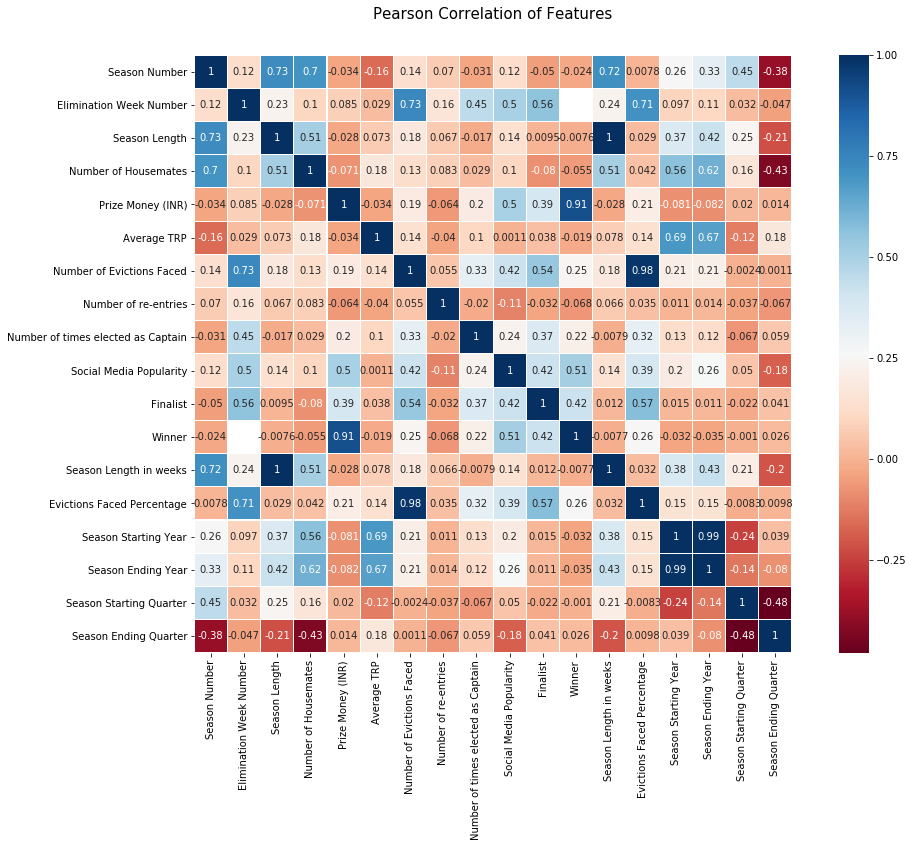

In [86]:
# Correlation matrix (Heatmap style)
corrmat = bigg_boss.corr()
f, ax = plt.subplots(figsize=(17, 11))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corrmat, vmax=1.0, linewidths=0.1, square=True, cmap="RdBu", linecolor='white', annot=True);

In [87]:
# Crosschecking Actor/Actress Gender
bigg_boss[bigg_boss['Profession'].str.contains('Act')].groupby('Gender')['Profession'].value_counts().unstack()
#bigg_boss.loc[(bigg_boss['Profession']=='Actress') & (bigg_boss['Gender']=='Male')]

Profession,Activist,Actor,Actor & Actress,Actress,Soap Actor,Soap Actress,Stage Actress
Gender,,,,,,,
Couple,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Female,3.0,NaN,NaN,162.0,NaN,60.0,2.0
Male,4.0,120.0,NaN,NaN,37.0,NaN,NaN


In [88]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))

import matplotlib
print("matplotlib version: {}". format(matplotlib. __version__))
print("seaborn version: {}". format(sns.__version__))

import sklearn
print("sklearn version: {}". format(sklearn.__version__))

# numpy version: 1.16.4
# pandas version: 0.25.2
# matplotlib version: 3.0.3
# seaborn version: 0.9.0
# sklearn version: 0.21.3

numpy version: 1.16.4
pandas version: 0.25.2
matplotlib version: 3.0.3
seaborn version: 0.9.0
sklearn version: 0.21.3
